In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
import torchvision.models as models


In [0]:
!unzip rsna_stage1_png_128.zip -d /stage1_image/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /stage1_image/stage_1_train_images/ID_fe19193b3.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe19266e1.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe192f4f6.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe193f9de.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe196108f.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe19784ac.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe19a2c4f.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe19a4e64.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe19b70a2.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe19e5443.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe19f44ba.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe1a04a3d.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe1a2a02a.png  
  inflating: /stage1_image/stage_1_train_images/ID_fe1a3a548.png  
  inflating: /stage1_image/stage_1_

In [0]:
! pip install pydicom

     |████████████████████████████████| 35.3MB 95kB/s 


In [0]:
Data = "/stage1_image/stage_1_train_images/"
images = os.listdir(Data)

In [0]:
import pandas as pd
df=pd.read_csv('small_sample_stage1_new.csv')

In [0]:
## Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df,df['y'],test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,X_train['y'],test_size=0.125, random_state=0)

In [0]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from skimage import color

class ChestXrayDataset(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self,df, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.data_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 5])

        image = io.imread(img_name,as_gray=True)
        
        image = (image - image.mean()) / image.std()
            
        image_class = self.data_frame.iloc[idx, -2]

        sample = {'x': image[None,:], 'y': image_class}

        if self.transform:
            sample = self.transform(sample)

        return sample



In [0]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
#### Import vgg16 and changed some hyper-parameters

In [0]:
import torchvision.models as models

In [3]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [11]:
vgg16.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
!pip install --upgrade efficientnet-pytorch

Requirement already up-to-date: efficientnet-pytorch in /usr/local/lib/python3.6/dist-packages (0.6.3)


In [8]:
#### Import efficientnet-b7 and changed some hyper-parameters

In [0]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7') 

Loaded pretrained weights for efficientnet-b7


In [0]:
##Changed some hyper parameters for the input layer of efficientnet-b7 to improve it
model._conv_stem=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
model.cuda()

EfficientNet(
  (_conv_stem): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
        (static_padding): Identity()
      )
      (_b

In [0]:
import time
import copy
import torch.nn.functional as F
device = torch.device('cuda')




transformed_dataset = {'train': ChestXrayDataset(X_train,'/stage1_image/stage_1_train_images/'), \
                       'validate':ChestXrayDataset(X_val,'/stage1_image/stage_1_train_images/'),\
                       'test':ChestXrayDataset(X_test,'/stage1_image/stage_1_train_images/')
                       }



bs = 8
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs, shuffle=True, num_workers=0) \
              for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [0]:
import time
import copy
device = torch.device('cuda')




transformed_dataset = {'train': ChestXrayDataset(X_train,'/stage1_image/stage_1_train_images/'),\
                       'validate':ChestXrayDataset(X_val,'/stage1_image/stage_1_train_images/'),\
                       'test':ChestXrayDataset(X_test,'/stage1_image/stage_1_train_images/'),\
                       }



bs = 8
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs, shuffle=True, num_workers=0) \
              for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

def train_model(model, dataloader, optimizer, loss_fn, num_epochs=10, verbose = False, scheduler=None):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data['x'].to(device,dtype=torch.float)
                label = data['y'].to(device,dtype=torch.long)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                if scheduler:
                    scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict

In [0]:
import torch.optim as optim
import torch.nn as nn
loss_fn= nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

### For baseline model vgg

In [2]:
model_vgg, acc_dict_vgg, loss_dict_vgg=train_model(vgg16, dataloader, optimizer, loss_fn, num_epochs=10, verbose = True,scheduler=None)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.8079 Acc: 0.7025
Phase:validate, epoch loss: 0.6125 Acc: 0.8503
Epoch: 1/9
----------
Phase:train, epoch loss: 0.6862 Acc: 0.7922
Phase:validate, epoch loss: 0.5835 Acc: 0.8797
Epoch: 2/9
----------
Phase:train, epoch loss: 0.5316 Acc: 0.8381
Phase:validate, epoch loss: 0.4617 Acc: 0.8991
Epoch: 3/9
----------
Phase:train, epoch loss:0.4311  Acc: 0.8518
Phase:validate, epoch loss: 0.3566 Acc: 0.8905
Epoch: 4/9
----------
Phase:train, epoch loss: 0.4112 Acc: 0.8713
Phase:validate, epoch loss: 0.2918 Acc: 0.8924
Epoch: 5/9
----------
Phase:train, epoch loss: 0.3412 Acc: 0.8862
Phase:validate, epoch loss: 0.2829 Acc: 0.8871
Epoch: 6/9
----------
Phase:train, epoch loss: 0.3099 Acc: 0.8987
Phase:validate, epoch loss: 0.2635 Acc: 0.8985
Epoch: 7/9
----------
Phase:train, epoch loss: 0.2817 Acc: 0.9039
Phase:validate, epoch loss: 0.2401 Acc: 0.8893
Epoch: 8/9
----------
Phase:train, epoch loss: 0.2903 Acc: 0.9052
Phase:validate, epoch loss:0.2

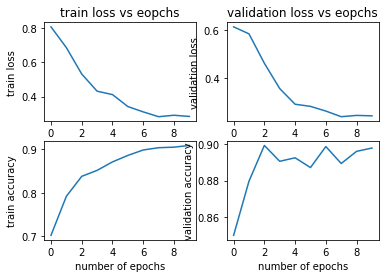

In [18]:

import matplotlib.pyplot as plt
plot=plt.figure()
fig=plot.add_subplot(2,2,1)
plt.plot(loss_dict_vgg['train'])
plt.xlabel('number of epochs')
plt.ylabel('train loss')
plt.title('train loss vs eopchs')

fig=plot.add_subplot(2,2,2)
plt.plot(loss_dict_vgg['validate'])
plt.xlabel('number of epochs')
plt.ylabel('validation loss')
plt.title('validation loss vs eopchs')
fig=plot.add_subplot(2,2,3)
plt.plot(acc_dict_vgg['train'])
plt.xlabel('number of epochs')
plt.ylabel('train accuracy')


fig=plot.add_subplot(2,2,4)
plt.plot(acc_dict_vgg['validate'])
plt.xlabel('number of epochs')
plt.ylabel('validation accuracy')
plt.show()

In [0]:
def evaluate_model(model, dataloader,loss_fn, phase = 'validate'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    for data in dataloader[phase]:
        image = data[0].to(device)
        label = data[1].to(device)
        output = model(image)
        loss = loss_fn(output, label)
        _, preds = torch.max(output,dim = 1)
        num_imgs = image.size()[0]
        running_correct += torch.sum(preds ==label).item()
        running_loss += loss.item()*num_imgs
        running_total += num_imgs
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    return accuracy, loss

In [0]:
### To evaluate the test accuracy and test loss for vgg16
test_acc_vgg, test_loss_vgg = evaluate_model(vgg16, dataloader,cel,phase = 'test')

In [21]:
test_acc_vgg


0.8958

In [22]:
test_loss_vgg

0.2513

### For Efficient Net B7

In [11]:
import time
import copy
device = torch.device('cuda')




transformed_dataset = {'train': ChestXrayDataset(X_train,'/stage1_image/stage_1_train_images/'),\
                       'validate':ChestXrayDataset(X_val,'/stage1_image/stage_1_train_images/'),\
                       'test':ChestXrayDataset(X_test,'/stage1_image/stage_1_train_images/'),\
                       }



bs = 8
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs, shuffle=True, num_workers=0) \
              for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

def train_model(model, dataloader, optimizer, loss_fn, num_epochs=10, verbose = False, scheduler=None):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data['x'].to(device,dtype=torch.float)
                label = data['y'].to(device,dtype=torch.long)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                if scheduler:
                    scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict


In [12]:
import torch.optim as optim
import torch.nn as nn
loss_fn= nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [1]:
model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, loss_fn, num_epochs=10, verbose = True,scheduler=None)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.6078 Acc: 0.7815
Phase:validate, epoch loss: 0.5128 Acc: 0.9010
Epoch: 1/9
----------
Phase:train, epoch loss: 0.3872 Acc: 0.8522
Phase:validate, epoch loss: 0.3815 Acc: 0.9117
Epoch: 2/9
----------
Phase:train, epoch loss: 0.3216 Acc: 0.8791
Phase:validate, epoch loss: 0.2917 Acc: 0.9166
Epoch: 3/9
----------
Phase:train, epoch loss:0.2811  Acc: 0.8918
Phase:validate, epoch loss: 0.2526 Acc: 0.9102
Epoch: 4/9
----------
Phase:train, epoch loss: 0.2612 Acc: 0.9011
Phase:validate, epoch loss: 0.2318 Acc: 0.9059
Epoch: 5/9
----------
Phase:train, epoch loss: 0.2452 Acc: 0.9032
Phase:validate, epoch loss: 0.2209 Acc: 0.9197
Epoch: 6/9
----------
Phase:train, epoch loss: 0.2399 Acc: 0.9078
Phase:validate, epoch loss: 0.2235 Acc: 0.9069
Epoch: 7/9
----------
Phase:train, epoch loss: 0.2317 Acc: 0.9113
Phase:validate, epoch loss: 0.2201 Acc: 0.9135
Epoch: 8/9
----------
Phase:train, epoch loss: 0.2303 Acc: 0.9155
Phase:validate, epoch loss:0.2

In [1]:
### We can see efficientNet-b7 used quite less time than vggnet, thus efficientNet-b7 is better for large data set

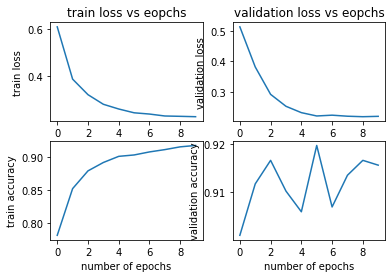

In [22]:
import matplotlib.pyplot as plt
plot=plt.figure()
fig=plot.add_subplot(2,2,1)
plt.plot(loss_dict['train'])
plt.xlabel('number of epochs')
plt.ylabel('train loss')
plt.title('train loss vs eopchs')

fig=plot.add_subplot(2,2,2)
plt.plot(loss_dict['validate'])
plt.xlabel('number of epochs')
plt.ylabel('validation loss')
plt.title('validation loss vs eopchs')
fig=plot.add_subplot(2,2,3)
plt.plot(acc_dict['train'])
plt.xlabel('number of epochs')
plt.ylabel('train accuracy')


fig=plot.add_subplot(2,2,4)
plt.plot(acc_dict['validate'])
plt.xlabel('number of epochs')
plt.ylabel('validation accuracy')
plt.show()

In [0]:
test_acc, test_loss = evaluate_model(model_vgg, dataloader,cel,phase = 'test')

In [3]:
test_acc

0.9103

In [10]:
test_loss

0.2837

In [1]:
####Plot the roc graph for EfficientNet

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [0]:
def inference(model_ft,loader):
    use_gpu = 1
    model_ft.eval()
    whole_output =[]
    whole_target = []

    for valData in loader:
        data = valData['x']
        target = valData['y']
        if use_gpu:
            data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
            target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
        else:
            data, target = Variable(data,volatile=True).type(torch.FloatTensor), Variable(target,volatile=True).type(torch.LongTensor)

        output =F.softmax(model_ft(data),dim=1)
        whole_output.append( output.cpu().data.numpy())
        whole_target.append( valData['y'].numpy())

    whole_output = np.concatenate(whole_output)
    whole_target = np.concatenate(whole_target)

    y_score = whole_output
    y_target = label_binarize(whole_target, classes=[0, 1])
    
    return y_score, y_target

In [2]:
from torch.autograd import Variable
y_s, y_t=inference(model,dataloader['test'])

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_t[:, i], y_s[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [0]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_t[:, i], y_s[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_t.ravel(), y_s.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment


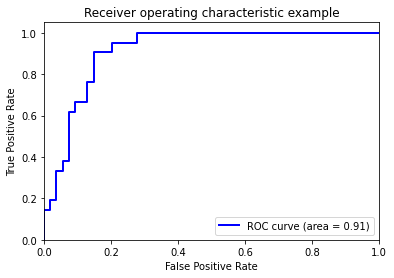

In [0]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='b',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()